In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import openslide
import os
import openslide
from PIL import Image
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".svs"):
            path = os.path.join(folder, filename)
            slide = openslide.OpenSlide(path)
            level_count = slide.level_count
            level_dimensions = slide.level_dimensions
            level = 0  # Assuming level 0 has the lowest resolution
            width, height = level_dimensions[level]

            # Load a region of the slide (e.g., top-left corner)
            region = slide.read_region(location=(0, 0), level=level, size=(width // 10, height // 10))
            image = region.convert("RGB")

            images.append(image)
            labels.append(label)
    return images, labels

# Load LGG and GBM images with labels
train_lgg_images, train_lgg_labels = load_images_from_folder("/kaggle/input/training-lgg/lgg", label="lgg")
train_gbm_images, train_gbm_labels = load_images_from_folder("/kaggle/input/gbm-training-dataset/gbm", label="gbm")
test_images, _ = load_images_from_folder("/kaggle/input/test-dataset-tumor/test_folder", label=None)


In [8]:
import torch
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Move model to appropriate device
clip_model.to(device)

# Extract features for training images
def extract_features(images, labels):
    features = []
    for image, label in zip(images, labels):
        inputs = clip_processor(text=label, images=image, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  # Move inputs to device
        with torch.no_grad():
            image_features = clip_model.get_image_features(pixel_values=inputs["pixel_values"])
        features.append(image_features.cpu().numpy())
    return features

# Extract features for training and testing images
train_lgg_features = extract_features(train_lgg_images, train_lgg_labels)
train_gbm_features = extract_features(train_gbm_images, train_gbm_labels)
test_features = extract_features(test_images, [None]*len(test_images))  # No labels for test set


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2024-04-06 18:50:21.589502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 18:50:21.589604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 18:50:21.723360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one h

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Combine features and labels
X_train_flat = np.concatenate((train_lgg_features, train_gbm_features)).reshape(-1, train_lgg_features[0].shape[-1])
y_train = np.concatenate((train_lgg_labels, train_gbm_labels))

# Train logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_flat, y_train)

# Make predictions
def predict(features):
    features_flat = features.reshape(features.shape[0], -1)
    predictions = classifier.predict(features_flat)
    return predictions

# Evaluate performance
def evaluate(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Evaluate on training set
train_predictions = predict(np.concatenate((train_lgg_features, train_gbm_features)))
train_accuracy = evaluate(train_predictions, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 1.0


In [10]:
# Make predictions on test set
test_predictions = predict(np.concatenate(test_features))

# Display predictions
for i, prediction in enumerate(test_predictions):
    if prediction == "lgg":
        print(f"Test image {i+1} is classified as LGG.")
    else:
        print(f"Test image {i+1} is classified as GBM.")


Test image 1 is classified as LGG.
Test image 2 is classified as LGG.
Test image 3 is classified as LGG.
Test image 4 is classified as GBM.


In [11]:
# Obtain true labels for the test set
# Assuming you have the true labels stored in a variable called test_labels
# Replace 'test_labels' with the actual variable name if it's different
test_labels = ['lgg', 'lgg','gbm','gbm']  # Example of test labels, replace this with your actual test labels

# Make predictions on test set
test_predictions = predict(np.concatenate(test_features))

# Calculate testing accuracy
test_accuracy = evaluate(test_predictions, test_labels)
print("Testing Accuracy:", test_accuracy)


Testing Accuracy: 0.75


In [15]:
# Flatten the feature vectors
test_features_flat = np.vstack(test_features)

# Make predictions on the test set
test_predictions = classifier.predict(test_features_flat)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# Calculate precision, recall, and F1-score
precision_test = precision_score(test_labels, test_predictions, average='weighted')
recall_test = recall_score(test_labels, test_predictions, average='weighted')
f1_test = f1_score(test_labels, test_predictions, average='weighted')
print("Precision (Test):", precision_test)
print("Recall (Test):", recall_test)
print("F1-score (Test):", f1_test)

# Compute confusion matrix
conf_matrix_test = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix (Test):")
print(conf_matrix_test)


Test Accuracy: 0.75
Precision (Test): 0.8333333333333333
Recall (Test): 0.75
F1-score (Test): 0.7333333333333334
Confusion Matrix (Test):
[[1 1]
 [0 2]]


In [16]:
for i, (true_label, pred_label) in enumerate(zip(test_labels, test_predictions)):
    print(f"Sample {i+1}: True label - {true_label}, Predicted label - {pred_label}")

Sample 1: True label - lgg, Predicted label - lgg
Sample 2: True label - lgg, Predicted label - lgg
Sample 3: True label - gbm, Predicted label - lgg
Sample 4: True label - gbm, Predicted label - gbm


# PCA 


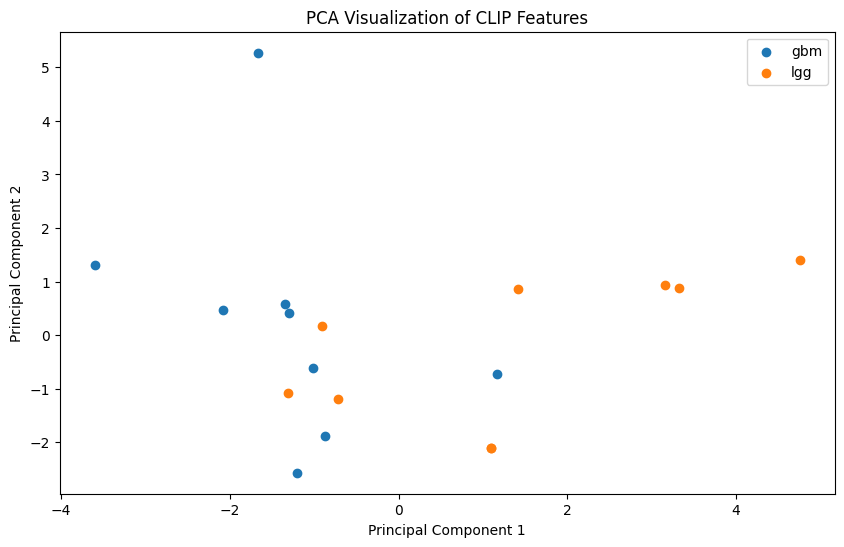

In [18]:
# Flatten the feature vectors
all_features_flat = all_features.reshape(all_features.shape[0], -1)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_features = pca.fit_transform(all_features_flat)

# Plot the PCA features
plt.figure(figsize=(10, 6))
for label in np.unique(all_labels):
    plt.scatter(pca_features[all_labels == label, 0], pca_features[all_labels == label, 1], label=label)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of CLIP Features')
plt.legend()
plt.show()


#  cross-validation 

In [19]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this as needed

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store accuracy scores for each fold
cv_train_accuracies = []
cv_val_accuracies = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X_train_flat, y_train), 1):
    print(f"Fold {fold}/{n_splits}:")
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train_flat[train_index], X_train_flat[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train logistic regression classifier
    classifier = LogisticRegression()
    classifier.fit(X_train_fold, y_train_fold)

    # Make predictions on training and validation sets
    train_predictions = classifier.predict(X_train_fold)
    val_predictions = classifier.predict(X_val_fold)

    # Calculate accuracy scores
    train_accuracy = accuracy_score(y_train_fold, train_predictions)
    val_accuracy = accuracy_score(y_val_fold, val_predictions)

    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {val_accuracy}\n")

    # Store accuracy scores
    cv_train_accuracies.append(train_accuracy)
    cv_val_accuracies.append(val_accuracy)

# Calculate average accuracy across all folds
avg_train_accuracy = np.mean(cv_train_accuracies)
avg_val_accuracy = np.mean(cv_val_accuracies)

print(f"Average Training Accuracy across all folds: {avg_train_accuracy}")
print(f"Average Validation Accuracy across all folds: {avg_val_accuracy}")


Fold 1/5:
Training Accuracy: 1.0
Validation Accuracy: 1.0

Fold 2/5:
Training Accuracy: 1.0
Validation Accuracy: 1.0

Fold 3/5:
Training Accuracy: 1.0
Validation Accuracy: 1.0

Fold 4/5:
Training Accuracy: 1.0
Validation Accuracy: 0.6666666666666666

Fold 5/5:
Training Accuracy: 1.0
Validation Accuracy: 1.0

Average Training Accuracy across all folds: 1.0
Average Validation Accuracy across all folds: 0.9333333333333332


Data Augmentation: Apply data augmentation techniques such as rotation, flipping, scaling, or adding noise to increase the diversity of your training data.


In [59]:
import openslide
import os
import openslide
from PIL import Image
import torch
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define data augmentation transforms
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".svs"):
            path = os.path.join(folder, filename)
            slide = openslide.OpenSlide(path)
            level_count = slide.level_count
            level_dimensions = slide.level_dimensions
            level = 0  # Assuming level 0 has the lowest resolution
            width, height = level_dimensions[level]

            # Load a region of the slide (e.g., top-left corner)
            region = slide.read_region(location=(0, 0), level=level, size=(width // 10, height // 10))
            image = region.convert("RGB")

            # Apply data augmentation
            image = data_transforms(image)
            
            images.append(image)
            labels.append(label)
    return images, labels

# Load LGG and GBM images with labels
train_lgg_images, train_lgg_labels = load_images_from_folder("/kaggle/input/training-lgg/lgg", label="lgg")
train_gbm_images, train_gbm_labels = load_images_from_folder("/kaggle/input/gbm-training-dataset/gbm", label="gbm")
test_images, _ = load_images_from_folder("/kaggle/input/test-dataset-tumor/test_folder", label=None)


In [60]:

# Load CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Move model to appropriate device
clip_model.to(device)

# Extract features for training images
def extract_features(images, labels):
    features = []
    for image, label in zip(images, labels):
        inputs = clip_processor(text=label, images=image.unsqueeze(0), return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  # Move inputs to device
        with torch.no_grad():
            image_features = clip_model.get_image_features(pixel_values=inputs["pixel_values"])
        features.append(image_features.cpu().numpy())
    return features


# Extract features for training and testing images
train_lgg_features = extract_features(train_lgg_images, train_lgg_labels)
train_gbm_features = extract_features(train_gbm_images, train_gbm_labels)
test_features = extract_features(test_images, [None]*len(test_images))  # No labels for test set

# Combine features and labels
X_train_flat = np.concatenate((train_lgg_features, train_gbm_features)).reshape(-1, train_lgg_features[0].shape[-1])
y_train = np.concatenate((train_lgg_labels, train_gbm_labels))

# Train logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_flat, y_train)

# Make predictions
def predict(features):
    features_flat = features.reshape(features.shape[0], -1)
    predictions = classifier.predict(features_flat)
    return predictions

# Evaluate performance
def evaluate(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Evaluate on training set
train_predictions = predict(np.concatenate((train_lgg_features, train_gbm_features)))
train_accuracy = evaluate(train_predictions, y_train)
print("Training Accuracy:", train_accuracy)

# Make predictions on test set
test_predictions = predict(np.concatenate(test_features))

# Display predictions
for i, prediction in enumerate(test_predictions):
    if prediction == "lgg":
        print(f"Test image {i+1} is classified as LGG.")
    else:
        print(f"Test image {i+1} is classified as GBM.")


Training Accuracy: 0.7142857142857143
Test image 1 is classified as LGG.
Test image 2 is classified as GBM.
Test image 3 is classified as GBM.
Test image 4 is classified as LGG.


with data augumentation and using svm and random forest for classifying

In [63]:
import openslide
import os
import openslide
from PIL import Image
import torch
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define data augmentation transforms
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".svs"):
            path = os.path.join(folder, filename)
            slide = openslide.OpenSlide(path)
            level_count = slide.level_count
            level_dimensions = slide.level_dimensions
            level = 0  # Assuming level 0 has the lowest resolution
            width, height = level_dimensions[level]

            # Load a region of the slide (e.g., top-left corner)
            region = slide.read_region(location=(0, 0), level=level, size=(width // 10, height // 10))
            image = region.convert("RGB")

            # Apply data augmentation
            image = data_transforms(image)
            
            images.append(image)
            labels.append(label)
    return images, labels

# Load LGG and GBM images with labels
train_lgg_images, train_lgg_labels = load_images_from_folder("/kaggle/input/training-lgg/lgg", label="lgg")
train_gbm_images, train_gbm_labels = load_images_from_folder("/kaggle/input/gbm-training-dataset/gbm", label="gbm")
test_images, _ = load_images_from_folder("/kaggle/input/test-dataset-tumor/test_folder", label=None)

# Load CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Move model to appropriate device
clip_model.to(device)

# Extract features for training images
def extract_features(images, labels):
    features = []
    for image, label in zip(images, labels):
        inputs = clip_processor(text=label, images=image.unsqueeze(0), return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  # Move inputs to device
        with torch.no_grad():
            image_features = clip_model.get_image_features(pixel_values=inputs["pixel_values"])
        features.append(image_features.cpu().numpy())
    return features


# Extract features for training and testing images
train_lgg_features = extract_features(train_lgg_images, train_lgg_labels)
train_gbm_features = extract_features(train_gbm_images, train_gbm_labels)
test_features = extract_features(test_images, [None]*len(test_images))  # No labels for test set

# Combine features and labels
X_train_flat = np.concatenate((train_lgg_features, train_gbm_features)).reshape(-1, train_lgg_features[0].shape[-1])
y_train = np.concatenate((train_lgg_labels, train_gbm_labels))

# Train SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_flat, y_train)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_flat, y_train)

# Make predictions
def predict(classifier, features):
    features_flat = features.reshape(features.shape[0], -1)
    predictions = classifier.predict(features_flat)
    return predictions

# Evaluate performance
def evaluate(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Evaluate SVM on training set
train_svm_predictions = predict(svm_classifier, np.concatenate((train_lgg_features, train_gbm_features)))
train_svm_accuracy = evaluate(train_svm_predictions, y_train)
print("SVM Training Accuracy:", train_svm_accuracy)

# Evaluate Random Forest on training set
train_rf_predictions = predict(rf_classifier, np.concatenate((train_lgg_features, train_gbm_features)))
train_rf_accuracy = evaluate(train_rf_predictions, y_train)
print("Random Forest Training Accuracy:", train_rf_accuracy)

# Make predictions on test set using SVM
test_svm_predictions = predict(svm_classifier, np.concatenate(test_features))

# Display predictions
for i, prediction in enumerate(test_svm_predictions):
    if prediction == "lgg":
        print(f"Test image {i+1} is classified as LGG (SVM).")
    else:
        print(f"Test image {i+1} is classified as GBM (SVM).")

# Make predictions on test set using Random Forest
test_rf_predictions = predict(rf_classifier, np.concatenate(test_features))

# Display predictions
for i, prediction in enumerate(test_rf_predictions):
    if prediction == "lgg":
        print(f"Test image {i+1} is classified as LGG (Random Forest).")
    else:
        print(f"Test image {i+1} is classified as GBM (Random Forest).")


SVM Training Accuracy: 0.7142857142857143
Random Forest Training Accuracy: 1.0
Test image 1 is classified as GBM (SVM).
Test image 2 is classified as LGG (SVM).
Test image 3 is classified as GBM (SVM).
Test image 4 is classified as GBM (SVM).
Test image 1 is classified as LGG (Random Forest).
Test image 2 is classified as LGG (Random Forest).
Test image 3 is classified as LGG (Random Forest).
Test image 4 is classified as LGG (Random Forest).
